# Amazon Electronics Dataset Visualization

This notebook provides comprehensive visualizations of the Amazon Electronics dataset characteristics to understand the data distribution and patterns.

**Data Source**: Amazon Reviews 2023 dataset by McAuley Lab

**Citation**: Hou et al. (2024) - Bridging Language and Items for Retrieval and Recommendation (arXiv:2403.03952)

## Key Characteristics to Visualize:

1. **Review Distribution** - Number of reviews per product, review ratings distribution
2. **Price Analysis** - Price ranges, price vs popularity correlation
3. **Product Categories** - Category distribution, hierarchical category analysis
4. **Rating Patterns** - Average ratings distribution, rating vs review count
5. **Temporal Trends** - Review trends over time, seasonal patterns
6. **Text Analysis** - Review length distribution, title/description characteristics
7. **Store Analysis** - Top stores/brands, store performance metrics
8. **Product Features** - Feature availability, product attribute analysis

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter, defaultdict
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime
import re

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Configure plot settings
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Set paths
DATA_DIR = Path("../data")
PROCESSED_DIR = DATA_DIR / "processed"

print("📊 Amazon Electronics Dataset Visualization Notebook")
print("=" * 50)


📊 Amazon Electronics Dataset Visualization Notebook


## Data Loading

Load the processed dataset files for visualization analysis.

In [4]:
def load_data():
    """Load processed dataset files."""
    
    # Load product metadata
    products_file = PROCESSED_DIR / "electronics_top1000_products.jsonl"
    reviews_file = PROCESSED_DIR / "electronics_top1000_products_reviews.jsonl"
    
    if not products_file.exists():
        print("❌ Processed data files not found. Please run data_preprocessing.ipynb first.")
        return None, None
    
    # Load products
    products = []
    with open(products_file, 'r', encoding='utf-8') as f:
        for line in f:
            products.append(json.loads(line.strip()))
    
    # Load reviews
    reviews = []
    with open(reviews_file, 'r', encoding='utf-8') as f:
        for line in f:
            reviews.append(json.loads(line.strip()))
    
    print(f"✅ Loaded {len(products)} products and {len(reviews)} reviews")
    return products, reviews

# Load the data
products_data, reviews_data = load_data()

if products_data:
    # Convert to DataFrames
    df_products = pd.DataFrame(products_data)
    df_reviews = pd.DataFrame(reviews_data)
    
    print(f"\n📈 Dataset Overview:")
    print(f"Products: {len(df_products):,}")
    print(f"Reviews: {len(df_reviews):,}")
    print(f"Product fields: {list(df_products.columns)}")
    print(f"Review fields: {list(df_reviews.columns)}")


✅ Loaded 1000 products and 20000 reviews

📈 Dataset Overview:
Products: 1,000
Reviews: 20,000
Product fields: ['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together', 'review_count']
Review fields: ['asin', 'parent_asin', 'rating', 'title', 'text', 'timestamp', 'verified_purchase', 'helpful_vote']


## 1. Review Distribution Analysis

Analyze the distribution of reviews across products and rating patterns.

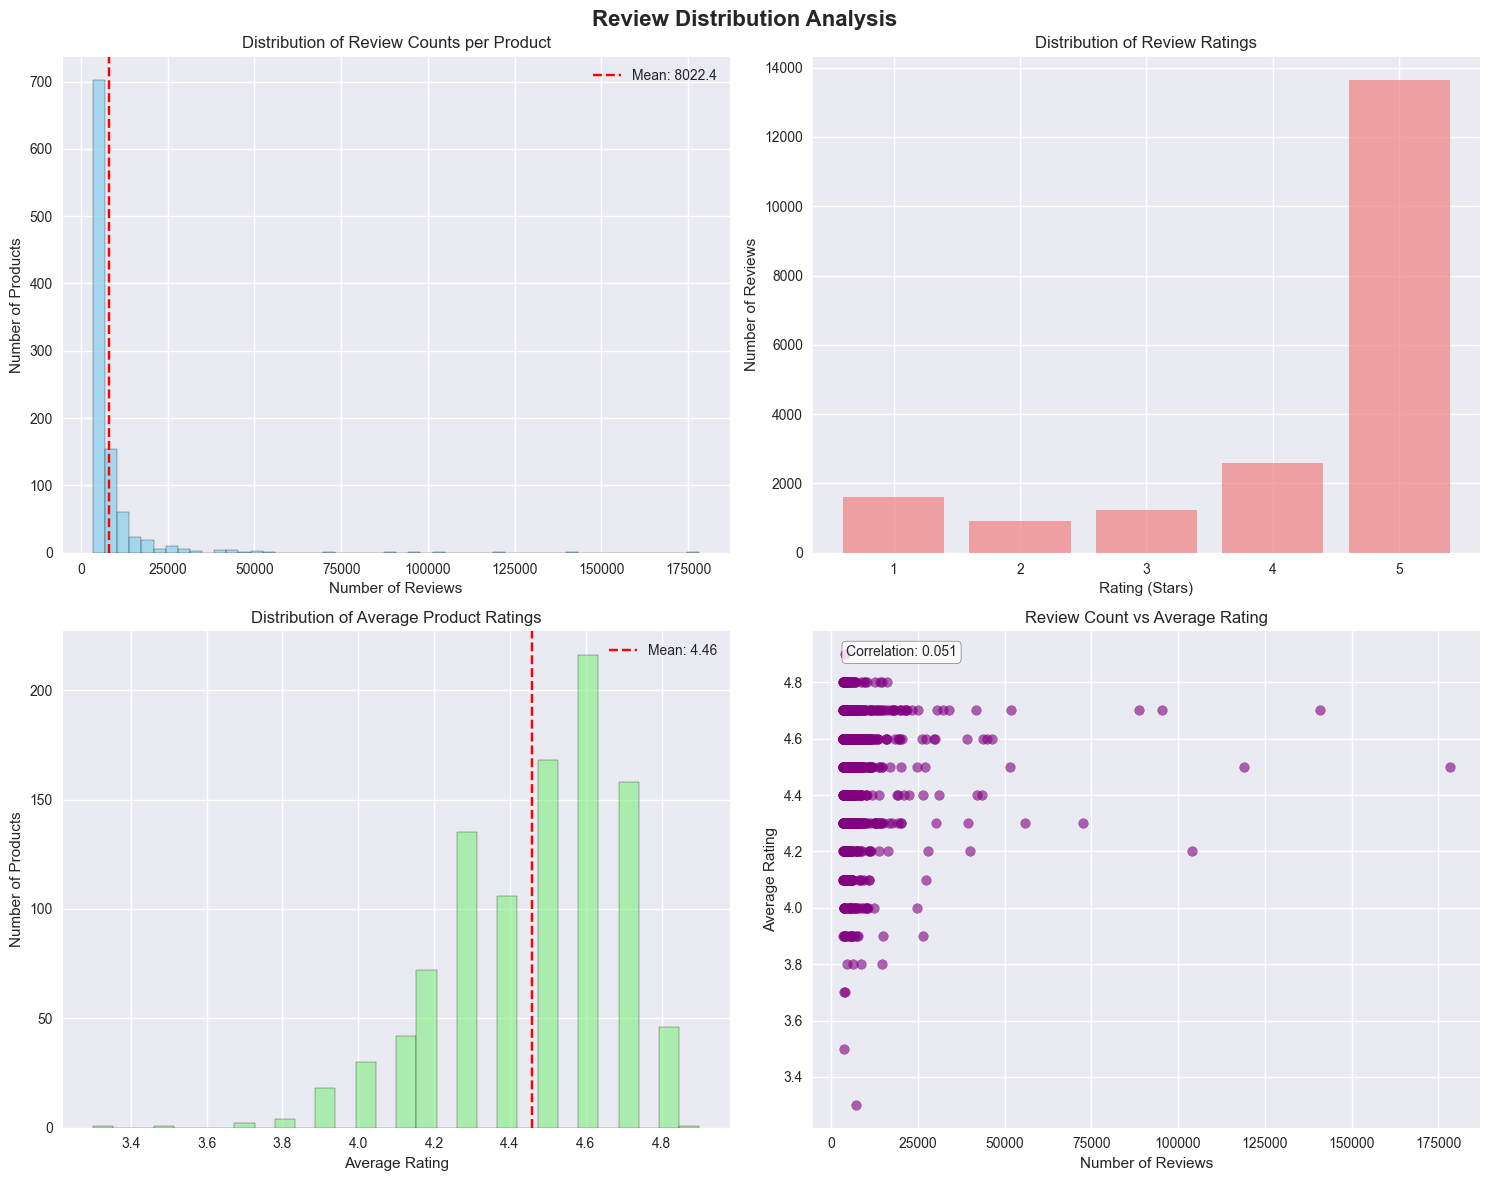


📊 Review Distribution Summary:
Total reviews analyzed: 20,000
Review count per product - Mean: 8022.4, Median: 5331.5
Average review rating: 4.29
Rating distribution: {1.0: np.int64(1616), 2.0: np.int64(904), 3.0: np.int64(1244), 4.0: np.int64(2599), 5.0: np.int64(13637)}


In [5]:
if products_data:
    # Create subplots for review distribution analysis
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Review Distribution Analysis', fontsize=16, fontweight='bold')
    
    # 1. Review count distribution
    review_counts = df_products['review_count'].dropna()
    axes[0, 0].hist(review_counts, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Distribution of Review Counts per Product')
    axes[0, 0].set_xlabel('Number of Reviews')
    axes[0, 0].set_ylabel('Number of Products')
    axes[0, 0].axvline(review_counts.mean(), color='red', linestyle='--', 
                       label=f'Mean: {review_counts.mean():.1f}')
    axes[0, 0].legend()
    
    # 2. Review ratings distribution
    if 'rating' in df_reviews.columns:
        ratings = df_reviews['rating'].dropna()
        rating_counts = ratings.value_counts().sort_index()
        axes[0, 1].bar(rating_counts.index, rating_counts.values, color='lightcoral', alpha=0.7)
        axes[0, 1].set_title('Distribution of Review Ratings')
        axes[0, 1].set_xlabel('Rating (Stars)')
        axes[0, 1].set_ylabel('Number of Reviews')
        axes[0, 1].set_xticks(range(1, 6))
    
    # 3. Average rating distribution
    if 'average_rating' in df_products.columns:
        avg_ratings = pd.to_numeric(df_products['average_rating'], errors='coerce').dropna()
        axes[1, 0].hist(avg_ratings, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
        axes[1, 0].set_title('Distribution of Average Product Ratings')
        axes[1, 0].set_xlabel('Average Rating')
        axes[1, 0].set_ylabel('Number of Products')
        axes[1, 0].axvline(avg_ratings.mean(), color='red', linestyle='--', 
                          label=f'Mean: {avg_ratings.mean():.2f}')
        axes[1, 0].legend()
    
    # 4. Review count vs Average rating scatter
    if 'average_rating' in df_products.columns:
        valid_data = df_products.dropna(subset=['review_count', 'average_rating'])
        x = pd.to_numeric(valid_data['review_count'])
        y = pd.to_numeric(valid_data['average_rating'])
        axes[1, 1].scatter(x, y, alpha=0.6, color='purple')
        axes[1, 1].set_title('Review Count vs Average Rating')
        axes[1, 1].set_xlabel('Number of Reviews')
        axes[1, 1].set_ylabel('Average Rating')
        
        # Add correlation coefficient
        corr = np.corrcoef(x, y)[0, 1]
        axes[1, 1].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                        transform=axes[1, 1].transAxes, fontsize=10,
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n📊 Review Distribution Summary:")
    print(f"Total reviews analyzed: {len(df_reviews):,}")
    print(f"Review count per product - Mean: {review_counts.mean():.1f}, Median: {review_counts.median():.1f}")
    if 'rating' in df_reviews.columns:
        print(f"Average review rating: {df_reviews['rating'].mean():.2f}")
        print(f"Rating distribution: {dict(df_reviews['rating'].value_counts().sort_index())}")
else:
    print("⚠️ No data available for visualization. Please run data preprocessing first.")


## 2. Price Analysis

Analyze product pricing patterns and relationships with popularity.

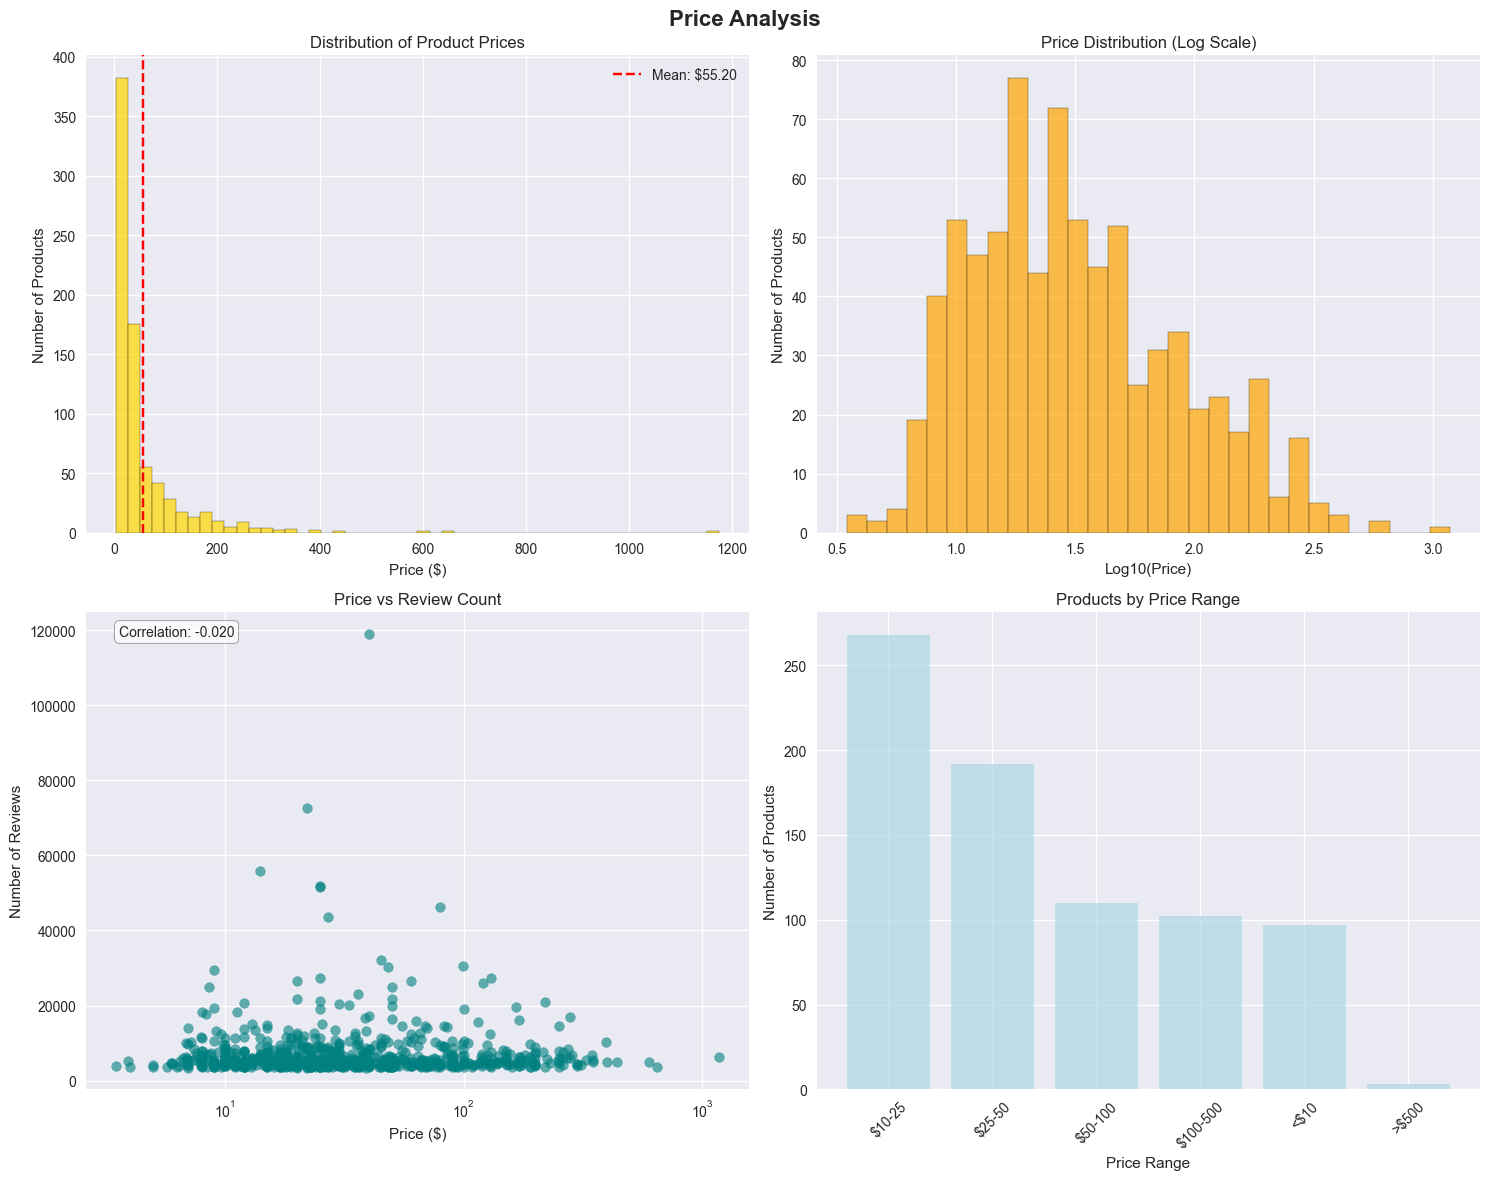


💰 Price Analysis Summary:
Products with price data: 772 (77.2%)
Price range: $3.49 - $1175.35
Mean price: $55.20
Median price: $26.99
Price percentiles:
  25th percentile: $14.99
  50th percentile: $26.99
  75th percentile: $59.99
  90th percentile: $136.99
  95th percentile: $199.43


In [6]:
if products_data and 'price' in df_products.columns:
    # Clean price data
    prices = pd.to_numeric(df_products['price'], errors='coerce').dropna()
    
    if len(prices) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Price Analysis', fontsize=16, fontweight='bold')
        
        # 1. Price distribution
        axes[0, 0].hist(prices, bins=50, alpha=0.7, color='gold', edgecolor='black')
        axes[0, 0].set_title('Distribution of Product Prices')
        axes[0, 0].set_xlabel('Price ($)')
        axes[0, 0].set_ylabel('Number of Products')
        axes[0, 0].axvline(prices.mean(), color='red', linestyle='--', 
                          label=f'Mean: ${prices.mean():.2f}')
        axes[0, 0].legend()
        
        # 2. Price distribution (log scale)
        log_prices = np.log10(prices[prices > 0])
        axes[0, 1].hist(log_prices, bins=30, alpha=0.7, color='orange', edgecolor='black')
        axes[0, 1].set_title('Price Distribution (Log Scale)')
        axes[0, 1].set_xlabel('Log10(Price)')
        axes[0, 1].set_ylabel('Number of Products')
        
        # 3. Price vs Review Count
        price_review_data = df_products.dropna(subset=['price', 'review_count'])
        if len(price_review_data) > 0:
            x = pd.to_numeric(price_review_data['price'])
            y = pd.to_numeric(price_review_data['review_count'])
            axes[1, 0].scatter(x, y, alpha=0.6, color='teal')
            axes[1, 0].set_title('Price vs Review Count')
            axes[1, 0].set_xlabel('Price ($)')
            axes[1, 0].set_ylabel('Number of Reviews')
            axes[1, 0].set_xscale('log')
            
            # Add correlation
            corr = np.corrcoef(x, y)[0, 1]
            axes[1, 0].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                           transform=axes[1, 0].transAxes, fontsize=10,
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # 4. Price ranges boxplot
        price_ranges = pd.cut(prices, bins=[0, 10, 25, 50, 100, 500, float('inf')], 
                             labels=['<$10', '$10-25', '$25-50', '$50-100', '$100-500', '>$500'])
        price_range_counts = price_ranges.value_counts()
        axes[1, 1].bar(range(len(price_range_counts)), price_range_counts.values, 
                       color='lightblue', alpha=0.7)
        axes[1, 1].set_title('Products by Price Range')
        axes[1, 1].set_xlabel('Price Range')
        axes[1, 1].set_ylabel('Number of Products')
        axes[1, 1].set_xticks(range(len(price_range_counts)))
        axes[1, 1].set_xticklabels(price_range_counts.index, rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Price statistics
        print("\n💰 Price Analysis Summary:")
        print(f"Products with price data: {len(prices):,} ({len(prices)/len(df_products)*100:.1f}%)")
        print(f"Price range: ${prices.min():.2f} - ${prices.max():.2f}")
        print(f"Mean price: ${prices.mean():.2f}")
        print(f"Median price: ${prices.median():.2f}")
        print(f"Price percentiles:")
        for p in [25, 50, 75, 90, 95]:
            print(f"  {p}th percentile: ${prices.quantile(p/100):.2f}")
    else:
        print("⚠️ No valid price data found for visualization.")
else:
    print("⚠️ Price data not available in the dataset.")


## 3. Product Categories Analysis

Analyze the distribution and hierarchy of product categories.

In [ ]:
if products_data and 'categories' in df_products.columns:
    # Extract and analyze categories
    all_categories = []
    category_paths = []
    
    for categories in df_products['categories']:
        if isinstance(categories, list) and len(categories) > 0:
            all_categories.extend(categories)
            category_paths.append(' > '.join(categories))
    
    if len(all_categories) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Product Categories Analysis', fontsize=16, fontweight='bold')
        
        # 1. Top level categories
        category_counts = Counter(all_categories)
        top_categories = dict(category_counts.most_common(15))
        
        axes[0, 0].barh(list(top_categories.keys()), list(top_categories.values()), 
                        color='lightcoral', alpha=0.7)
        axes[0, 0].set_title('Top 15 Categories (All Levels)')
        axes[0, 0].set_xlabel('Number of Products')
        axes[0, 0].tick_params(axis='y', labelsize=8)
        
        # 2. Category depth distribution
        category_depths = [len(cat) for cat in df_products['categories'] 
                          if isinstance(cat, list)]
        if category_depths:
            depth_counts = Counter(category_depths)
            axes[0, 1].bar(depth_counts.keys(), depth_counts.values(), 
                          color='skyblue', alpha=0.7)
            axes[0, 1].set_title('Category Hierarchy Depth Distribution')
            axes[0, 1].set_xlabel('Category Depth')
            axes[0, 1].set_ylabel('Number of Products')
        
        # 3. Top category paths
        if category_paths:
            path_counts = Counter(category_paths)
            top_paths = dict(path_counts.most_common(10))
            
            # Truncate long paths for display
            display_paths = [path[:50] + '...' if len(path) > 50 else path 
                           for path in top_paths.keys()]
            
            axes[1, 0].barh(range(len(display_paths)), list(top_paths.values()), 
                           color='lightgreen', alpha=0.7)
            axes[1, 0].set_title('Top 10 Category Paths')
            axes[1, 0].set_xlabel('Number of Products')
            axes[1, 0].set_yticks(range(len(display_paths)))
            axes[1, 0].set_yticklabels(display_paths, fontsize=8)
        
        # 4. First level category distribution
        first_level_cats = []
        for categories in df_products['categories']:
            if isinstance(categories, list) and len(categories) > 0:
                first_level_cats.append(categories[0])
        
        if first_level_cats:
            first_level_counts = Counter(first_level_cats).most_common(10)
            categories, counts = zip(*first_level_counts)
            
            axes[1, 1].pie(counts, labels=categories, autopct='%1.1f%%', 
                          startangle=90, colors=plt.cm.Set3.colors)
            axes[1, 1].set_title('Top 10 First-Level Categories')
        
        plt.tight_layout()
        plt.show()
        
        # Category statistics
        print("\n🏷️ Category Analysis Summary:")
        print(f"Products with category data: {len([c for c in df_products['categories'] if isinstance(c, list) and len(c) > 0])}")
        print(f"Total unique categories: {len(set(all_categories))}")
        print(f"Most common categories: {dict(category_counts.most_common(5))}")
        if category_depths:
            print(f"Average category depth: {np.mean(category_depths):.1f}")
            print(f"Category depth range: {min(category_depths)} - {max(category_depths)}")
    else:
        print("⚠️ No category data found for visualization.")
else:
    print("⚠️ Category data not available in the dataset.")


## 4. Store and Brand Analysis

Analyze the distribution of products across different stores and brands.

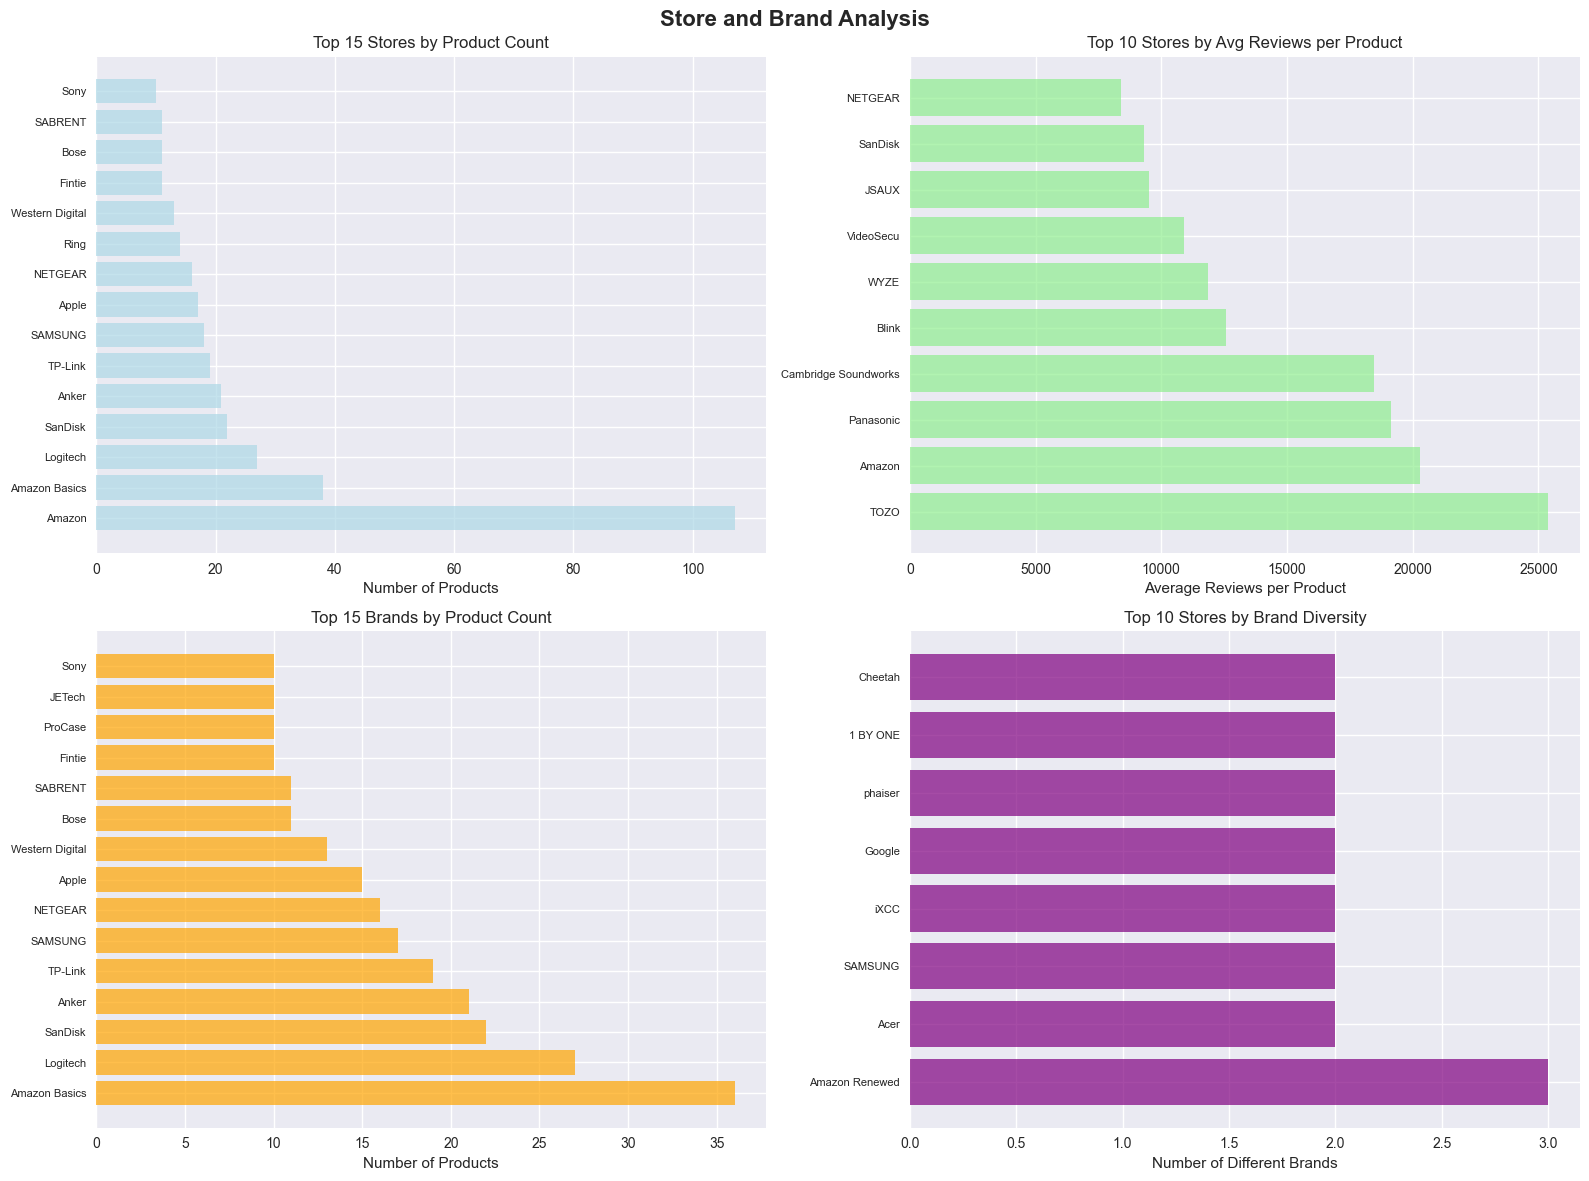


🏪 Store and Brand Analysis Summary:
Products with store data: 1,000 (100.0%)
Unique stores: 416
Top 5 stores: {'Amazon': 107, 'Amazon Basics': 38, 'Logitech': 27, 'SanDisk': 22, 'Anker': 21}
Products with brand data: 835
Unique brands: 397
Top 5 brands: {'Amazon Basics': 36, 'Logitech': 27, 'SanDisk': 22, 'Anker': 21, 'TP-Link': 19}


In [7]:
if products_data:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Store and Brand Analysis', fontsize=16, fontweight='bold')
    
    # 1. Top stores by product count
    if 'store' in df_products.columns:
        stores = df_products['store'].dropna()
        if len(stores) > 0:
            store_counts = stores.value_counts().head(15)
            axes[0, 0].barh(range(len(store_counts)), store_counts.values, 
                           color='lightblue', alpha=0.7)
            axes[0, 0].set_title('Top 15 Stores by Product Count')
            axes[0, 0].set_xlabel('Number of Products')
            axes[0, 0].set_yticks(range(len(store_counts)))
            axes[0, 0].set_yticklabels([store[:30] + '...' if len(store) > 30 else store 
                                       for store in store_counts.index], fontsize=8)
    
    # 2. Store performance (avg reviews per product)
    if 'store' in df_products.columns and 'review_count' in df_products.columns:
        store_performance = df_products.groupby('store')['review_count'].agg(['mean', 'count']).reset_index()
        store_performance = store_performance[store_performance['count'] >= 3]  # At least 3 products
        top_performing_stores = store_performance.nlargest(10, 'mean')
        
        if len(top_performing_stores) > 0:
            axes[0, 1].barh(range(len(top_performing_stores)), top_performing_stores['mean'], 
                           color='lightgreen', alpha=0.7)
            axes[0, 1].set_title('Top 10 Stores by Avg Reviews per Product')
            axes[0, 1].set_xlabel('Average Reviews per Product')
            axes[0, 1].set_yticks(range(len(top_performing_stores)))
            axes[0, 1].set_yticklabels([store[:25] + '...' if len(store) > 25 else store 
                                       for store in top_performing_stores['store']], fontsize=8)
    
    # 3. Brand analysis (from details)
    brands = []
    if 'details' in df_products.columns:
        for details in df_products['details']:
            if isinstance(details, dict) and 'Brand' in details:
                brands.append(details['Brand'])
    
    if len(brands) > 0:
        brand_counts = Counter(brands).most_common(15)
        brand_names, brand_values = zip(*brand_counts)
        
        axes[1, 0].barh(range(len(brand_names)), brand_values, 
                       color='orange', alpha=0.7)
        axes[1, 0].set_title('Top 15 Brands by Product Count')
        axes[1, 0].set_xlabel('Number of Products')
        axes[1, 0].set_yticks(range(len(brand_names)))
        axes[1, 0].set_yticklabels([brand[:25] + '...' if len(brand) > 25 else brand 
                                   for brand in brand_names], fontsize=8)
    
    # 4. Store vs Brand diversity
    store_brand_data = []
    if 'store' in df_products.columns and 'details' in df_products.columns:
        for idx, row in df_products.iterrows():
            store = row.get('store', '')
            details = row.get('details', {})
            brand = details.get('Brand', '') if isinstance(details, dict) else ''
            if store and brand:
                store_brand_data.append((store, brand))
    
    if len(store_brand_data) > 0:
        # Count unique brands per store
        store_brand_diversity = defaultdict(set)
        for store, brand in store_brand_data:
            store_brand_diversity[store].add(brand)
        
        diversity_data = [(store, len(brands)) for store, brands in store_brand_diversity.items() 
                         if len(brands) >= 2]  # At least 2 brands
        diversity_data.sort(key=lambda x: x[1], reverse=True)
        
        if len(diversity_data) > 0:
            top_diverse_stores = diversity_data[:10]
            store_names, brand_counts = zip(*top_diverse_stores)
            
            axes[1, 1].barh(range(len(store_names)), brand_counts, 
                           color='purple', alpha=0.7)
            axes[1, 1].set_title('Top 10 Stores by Brand Diversity')
            axes[1, 1].set_xlabel('Number of Different Brands')
            axes[1, 1].set_yticks(range(len(store_names)))
            axes[1, 1].set_yticklabels([store[:25] + '...' if len(store) > 25 else store 
                                       for store in store_names], fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Store and brand statistics
    print("\n🏪 Store and Brand Analysis Summary:")
    if 'store' in df_products.columns:
        stores = df_products['store'].dropna()
        print(f"Products with store data: {len(stores):,} ({len(stores)/len(df_products)*100:.1f}%)")
        print(f"Unique stores: {len(stores.unique()):,}")
        print(f"Top 5 stores: {dict(stores.value_counts().head().items())}")
    
    if len(brands) > 0:
        print(f"Products with brand data: {len(brands):,}")
        print(f"Unique brands: {len(set(brands)):,}")
        print(f"Top 5 brands: {dict(Counter(brands).most_common(5))}")
else:
    print("⚠️ No data available for store and brand analysis.")


## 5. Text Analysis

Analyze textual characteristics of product titles, descriptions, and reviews.

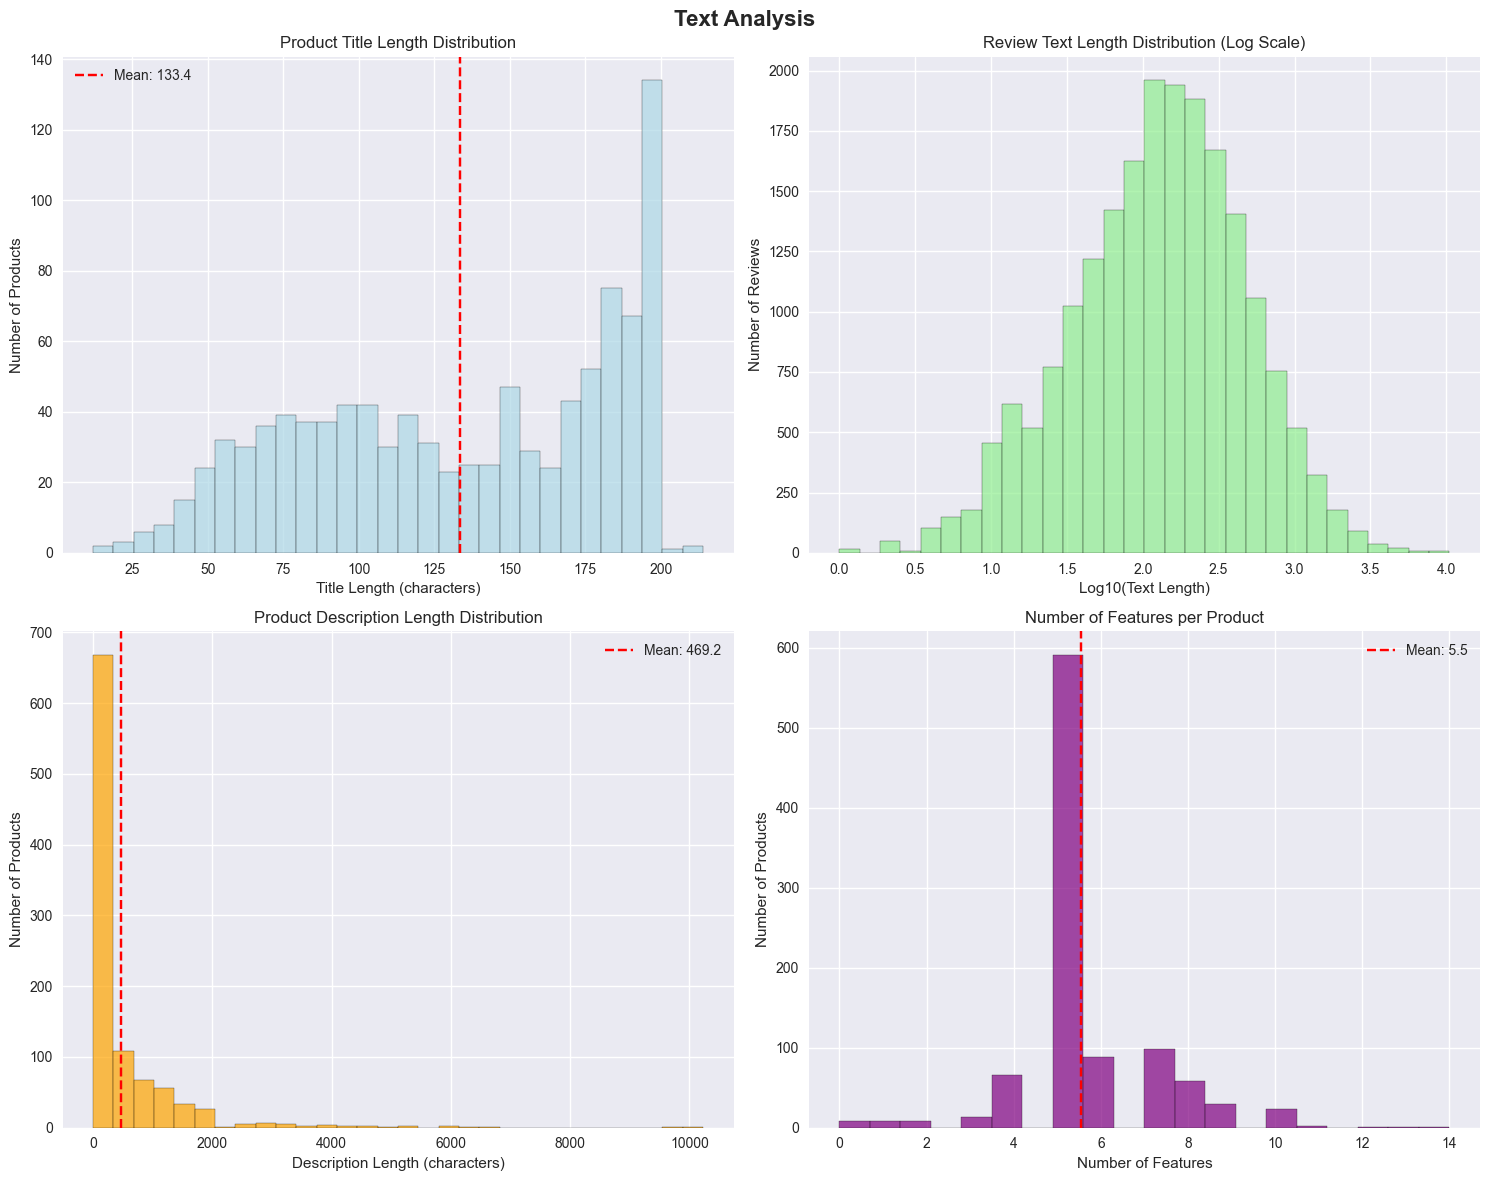


📝 Text Analysis Summary:
Product titles - Mean length: 133.4, Range: 12-214 characters
Review texts - Mean length: 273.9, Median: 137.0 characters
Review length percentiles: 25th=54, 75th=315, 95th=984
Product features - Mean count: 5.5, Max: 14 features per product


In [8]:
if products_data:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Text Analysis', fontsize=16, fontweight='bold')
    
    # 1. Product title length distribution
    if 'title' in df_products.columns:
        titles = df_products['title'].dropna()
        title_lengths = [len(title) for title in titles if isinstance(title, str)]
        
        if len(title_lengths) > 0:
            axes[0, 0].hist(title_lengths, bins=30, alpha=0.7, color='lightblue', edgecolor='black')
            axes[0, 0].set_title('Product Title Length Distribution')
            axes[0, 0].set_xlabel('Title Length (characters)')
            axes[0, 0].set_ylabel('Number of Products')
            axes[0, 0].axvline(np.mean(title_lengths), color='red', linestyle='--', 
                              label=f'Mean: {np.mean(title_lengths):.1f}')
            axes[0, 0].legend()
    
    # 2. Review text length distribution
    if reviews_data and 'text' in df_reviews.columns:
        review_texts = df_reviews['text'].dropna()
        review_lengths = [len(text) for text in review_texts if isinstance(text, str) and len(text) > 0]
        
        if len(review_lengths) > 0:
            # Use log scale for better visualization
            log_lengths = np.log10([l for l in review_lengths if l > 0])
            axes[0, 1].hist(log_lengths, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
            axes[0, 1].set_title('Review Text Length Distribution (Log Scale)')
            axes[0, 1].set_xlabel('Log10(Text Length)')
            axes[0, 1].set_ylabel('Number of Reviews')
    
    # 3. Product description length (if available)
    if 'description' in df_products.columns:
        descriptions = df_products['description'].dropna()
        desc_lengths = []
        for desc in descriptions:
            if isinstance(desc, list):
                desc_lengths.append(sum(len(d) for d in desc if isinstance(d, str)))
            elif isinstance(desc, str):
                desc_lengths.append(len(desc))
        
        if len(desc_lengths) > 0:
            axes[1, 0].hist(desc_lengths, bins=30, alpha=0.7, color='orange', edgecolor='black')
            axes[1, 0].set_title('Product Description Length Distribution')
            axes[1, 0].set_xlabel('Description Length (characters)')
            axes[1, 0].set_ylabel('Number of Products')
            axes[1, 0].axvline(np.mean(desc_lengths), color='red', linestyle='--', 
                              label=f'Mean: {np.mean(desc_lengths):.1f}')
            axes[1, 0].legend()
    
    # 4. Features count distribution
    if 'features' in df_products.columns:
        features = df_products['features'].dropna()
        feature_counts = [len(feat) if isinstance(feat, list) else 0 for feat in features]
        
        if len(feature_counts) > 0 and max(feature_counts) > 0:
            axes[1, 1].hist(feature_counts, bins=20, alpha=0.7, color='purple', edgecolor='black')
            axes[1, 1].set_title('Number of Features per Product')
            axes[1, 1].set_xlabel('Number of Features')
            axes[1, 1].set_ylabel('Number of Products')
            axes[1, 1].axvline(np.mean(feature_counts), color='red', linestyle='--', 
                              label=f'Mean: {np.mean(feature_counts):.1f}')
            axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Text analysis summary
    print("\n📝 Text Analysis Summary:")
    
    if 'title' in df_products.columns:
        titles = df_products['title'].dropna()
        title_lengths = [len(title) for title in titles if isinstance(title, str)]
        if title_lengths:
            print(f"Product titles - Mean length: {np.mean(title_lengths):.1f}, "
                  f"Range: {min(title_lengths)}-{max(title_lengths)} characters")
    
    if reviews_data and 'text' in df_reviews.columns:
        review_texts = df_reviews['text'].dropna()
        review_lengths = [len(text) for text in review_texts if isinstance(text, str) and len(text) > 0]
        if review_lengths:
            print(f"Review texts - Mean length: {np.mean(review_lengths):.1f}, "
                  f"Median: {np.median(review_lengths):.1f} characters")
            print(f"Review length percentiles: 25th={np.percentile(review_lengths, 25):.0f}, "
                  f"75th={np.percentile(review_lengths, 75):.0f}, "
                  f"95th={np.percentile(review_lengths, 95):.0f}")
    
    if 'features' in df_products.columns:
        features = df_products['features'].dropna()
        feature_counts = [len(feat) if isinstance(feat, list) else 0 for feat in features]
        if feature_counts:
            print(f"Product features - Mean count: {np.mean(feature_counts):.1f}, "
                  f"Max: {max(feature_counts)} features per product")
else:
    print("⚠️ No data available for text analysis.")


## 6. Temporal Analysis

Analyze temporal patterns in the review data.

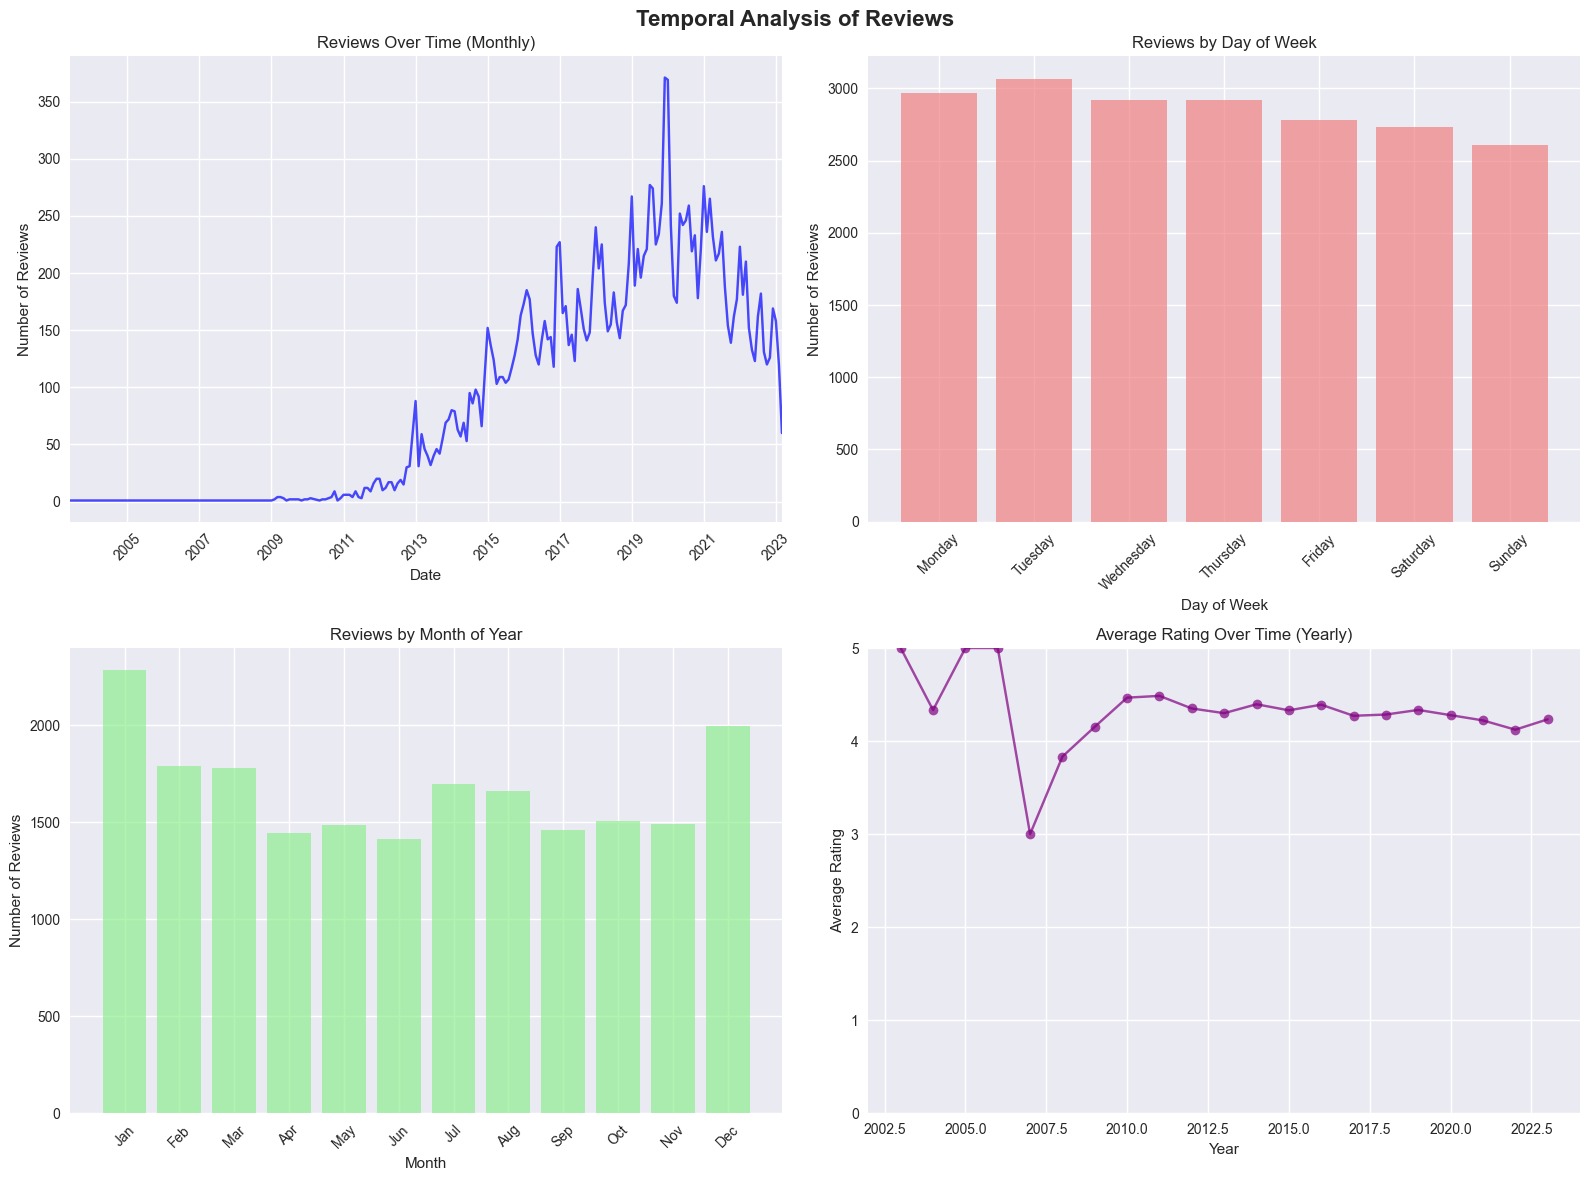


⏰ Temporal Analysis Summary:
Review date range: 2003-06-04 to 2023-03-18
Total time span: 7227 days
Most active day of week: Tuesday (3,068 reviews)
Most active month: January (2,283 reviews)
Reviews from 2020 onwards: 7,558 (37.8%)


In [22]:
if reviews_data and 'timestamp' in df_reviews.columns:
    # Convert timestamps to datetime
    timestamps = pd.to_numeric(df_reviews['timestamp'], errors='coerce').dropna()
    
    if len(timestamps) > 0:
        # Convert to datetime (timestamps are in milliseconds)
        dates = pd.to_datetime(timestamps, unit='ms')
        df_reviews_with_dates = df_reviews.copy()
        df_reviews_with_dates['date'] = pd.to_datetime(df_reviews['timestamp'], unit='ms', errors='coerce')
        df_reviews_with_dates = df_reviews_with_dates.dropna(subset=['date'])
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Temporal Analysis of Reviews', fontsize=16, fontweight='bold')
        
        # 1. Reviews over time (monthly)
        monthly_reviews = df_reviews_with_dates.groupby(df_reviews_with_dates['date'].dt.to_period('M')).size()
        monthly_reviews.plot(kind='line', ax=axes[0, 0], color='blue', alpha=0.7)
        axes[0, 0].set_title('Reviews Over Time (Monthly)')
        axes[0, 0].set_xlabel('Date')
        axes[0, 0].set_ylabel('Number of Reviews')
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # 2. Reviews by day of week
        df_reviews_with_dates['day_of_week'] = df_reviews_with_dates['date'].dt.day_name()
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        day_counts = df_reviews_with_dates['day_of_week'].value_counts().reindex(day_order)
        
        axes[0, 1].bar(day_counts.index, day_counts.values, color='lightcoral', alpha=0.7)
        axes[0, 1].set_title('Reviews by Day of Week')
        axes[0, 1].set_xlabel('Day of Week')
        axes[0, 1].set_ylabel('Number of Reviews')
        axes[0, 1].tick_params(axis='x', rotation=45)
        
        # 3. Reviews by month of year
        df_reviews_with_dates['month'] = df_reviews_with_dates['date'].dt.month_name()
        month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                      'July', 'August', 'September', 'October', 'November', 'December']
        month_counts = df_reviews_with_dates['month'].value_counts().reindex(month_order)
        
        axes[1, 0].bar(range(len(month_counts)), month_counts.values, color='lightgreen', alpha=0.7)
        axes[1, 0].set_title('Reviews by Month of Year')
        axes[1, 0].set_xlabel('Month')
        axes[1, 0].set_ylabel('Number of Reviews')
        axes[1, 0].set_xticks(range(len(month_counts)))
        axes[1, 0].set_xticklabels([m[:3] for m in month_order], rotation=45)
        
        # 4. Average rating over time (yearly)
        if 'rating' in df_reviews_with_dates.columns:
            yearly_ratings = df_reviews_with_dates.groupby(df_reviews_with_dates['date'].dt.year)['rating'].mean()
            yearly_ratings.plot(kind='line', ax=axes[1, 1], color='purple', marker='o', alpha=0.7)
            axes[1, 1].set_title('Average Rating Over Time (Yearly)')
            axes[1, 1].set_xlabel('Year')
            axes[1, 1].set_ylabel('Average Rating')
            axes[1, 1].set_ylim(0, 5)
        
        plt.tight_layout()
        plt.show()
        
        # Temporal analysis summary
        print("\n⏰ Temporal Analysis Summary:")
        print(f"Review date range: {dates.min().strftime('%Y-%m-%d')} to {dates.max().strftime('%Y-%m-%d')}")
        print(f"Total time span: {(dates.max() - dates.min()).days} days")
        
        # Peak activity analysis
        most_active_day = day_counts.idxmax()
        most_active_month = month_counts.idxmax()
        print(f"Most active day of week: {most_active_day} ({day_counts[most_active_day]:,} reviews)")
        print(f"Most active month: {most_active_month} ({month_counts[most_active_month]:,} reviews)")
        
        # Recent activity
        recent_reviews = df_reviews_with_dates[df_reviews_with_dates['date'] >= '2020-01-01']
        print(f"Reviews from 2020 onwards: {len(recent_reviews):,} ({len(recent_reviews)/len(df_reviews_with_dates)*100:.1f}%)")
        
    else:
        print("⚠️ No valid timestamp data found for temporal analysis.")
else:
    print("⚠️ No review data or timestamp field available for temporal analysis.")


## 7. Summary Dashboard

Create a comprehensive summary of all key insights from the dataset.

In [ ]:
if products_data:
    print("🎯 AMAZON ELECTRONICS DATASET - COMPREHENSIVE SUMMARY")
    print("=" * 60)
    
    # Dataset overview
    print(f"\n📊 DATASET OVERVIEW")
    print(f"   • Total Products: {len(df_products):,}")
    if reviews_data:
        print(f"   • Total Reviews: {len(df_reviews):,}")
        print(f"   • Avg Reviews per Product: {len(df_reviews)/len(df_products):.1f}")
    
    # Review insights
    if 'review_count' in df_products.columns:
        review_counts = df_products['review_count'].dropna()
        print(f"\n📈 POPULARITY METRICS")
        print(f"   • Most Reviewed Product: {review_counts.max():,} reviews")
        print(f"   • Least Reviewed Product: {review_counts.min():,} reviews")
        print(f"   • Median Reviews per Product: {review_counts.median():.0f}")
    
    # Price insights
    if 'price' in df_products.columns:
        prices = pd.to_numeric(df_products['price'], errors='coerce').dropna()
        if len(prices) > 0:
            print(f"\n💰 PRICING INSIGHTS")
            print(f"   • Price Range: ${prices.min():.2f} - ${prices.max():.2f}")
            print(f"   • Median Price: ${prices.median():.2f}")
            print(f"   • Products under $25: {len(prices[prices < 25]):,} ({len(prices[prices < 25])/len(prices)*100:.1f}%)")
            print(f"   • Products over $100: {len(prices[prices > 100]):,} ({len(prices[prices > 100])/len(prices)*100:.1f}%)")
    
    # Rating insights
    if reviews_data and 'rating' in df_reviews.columns:
        ratings = df_reviews['rating'].dropna()
        print(f"\n⭐ RATING INSIGHTS")
        print(f"   • Average Review Rating: {ratings.mean():.2f}/5.0")
        print(f"   • 5-star Reviews: {len(ratings[ratings == 5]):,} ({len(ratings[ratings == 5])/len(ratings)*100:.1f}%)")
        print(f"   • 1-star Reviews: {len(ratings[ratings == 1]):,} ({len(ratings[ratings == 1])/len(ratings)*100:.1f}%)")
    
    # Category insights
    if 'categories' in df_products.columns:
        all_categories = []
        for categories in df_products['categories']:
            if isinstance(categories, list) and len(categories) > 0:
                all_categories.extend(categories)
        
        if all_categories:
            category_counts = Counter(all_categories)
            print(f"\n🏷️ CATEGORY INSIGHTS")
            print(f"   • Total Unique Categories: {len(set(all_categories)):,}")
            print(f"   • Most Common Category: {category_counts.most_common(1)[0][0]} ({category_counts.most_common(1)[0][1]} products)")
    
    # Store insights
    if 'store' in df_products.columns:
        stores = df_products['store'].dropna()
        if len(stores) > 0:
            store_counts = stores.value_counts()
            print(f"\n🏪 STORE INSIGHTS")
            print(f"   • Total Unique Stores: {len(stores.unique()):,}")
            print(f"   • Top Store: {store_counts.index[0]} ({store_counts.iloc[0]} products)")
    
    # Text insights
    if 'title' in df_products.columns:
        titles = df_products['title'].dropna()
        title_lengths = [len(title) for title in titles if isinstance(title, str)]
        if title_lengths:
            print(f"\n📝 TEXT INSIGHTS")
            print(f"   • Avg Product Title Length: {np.mean(title_lengths):.0f} characters")
    
    if reviews_data and 'text' in df_reviews.columns:
        review_texts = df_reviews['text'].dropna()
        review_lengths = [len(text) for text in review_texts if isinstance(text, str) and len(text) > 0]
        if review_lengths:
            print(f"   • Avg Review Text Length: {np.mean(review_lengths):.0f} characters")
    
    # Data quality insights
    print(f"\n📋 DATA QUALITY")
    for col in ['price', 'average_rating', 'store', 'categories']:
        if col in df_products.columns:
            non_null_count = df_products[col].notna().sum()
            completeness = non_null_count / len(df_products) * 100
            print(f"   • {col.title()} Completeness: {completeness:.1f}% ({non_null_count:,}/{len(df_products):,})")
    
    print(f"\n✅ DATASET READY FOR RAG PIPELINE")
    print(f"   This filtered dataset provides a balanced mix of popular products")
    print(f"   with sufficient review data for effective retrieval and recommendation.")
    
else:
    print("⚠️ No data available for summary dashboard.")
